# **Capstone Project: Pneumonia Detection**

## **Context:** 
Computer vision can be used in health care for identifying diseases. In Pneumonia detection we need to detect Inflammation of  the  lungs.  In  this  challenge,  you’re  required  to  build  an  algorithm  to  detect  a  visual  signal  for  pneumonia  in  medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.

## **Data Description:** 
In the dataset, some of the features are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia. Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

## **Data Fields**
* patientId _- A patientId. Each patientId corresponds to a unique image.
* x_ - the upper-left x coordinate of the bounding box.
* y_ - the upper-left y coordinate of the bounding box.
* width_ - the width of the bounding box.
* height_ - the height of the bounding box.
* Target_ - the binary Target, indicating whether this sample has evidence of pneumonia.
All the images are in DICOM format.

## **Project Objective**
Design a DL based algorithm for detecting pneumonia

## Milestone 1

###  1. Import the data

#### Import the necessary libraries

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [146]:
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import zipfile
import os
from PIL import Image
import random
import pydicom
import cv2
import seaborn as sns
from glob import glob
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from skimage.transform import resize


# Keras Sequential Model
from tensorflow.keras.models import Sequential

# Importing all the different layers and optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm

In [8]:
#formatting numeric data for easier readability - 5 decimal places
pd.set_option("display.float_format", lambda x: "%.5f" % x)

#### Loading the dataset

In [10]:
# Defining Paths
train_labels = "C://Users//asus//Desktop//PGP_AIML//Capstone//Dataset//stage_2_train_labels.csv"
class_info = "C://Users//asus//Desktop//PGP_AIML//Capstone//Dataset//stage_2_detailed_class_info.csv"
sample_submission = "C://Users//asus//Desktop//PGP_AIML//Capstone//Dataset//stage_2_sample_submission.csv"
train_images = "C://Users//asus//Desktop//PGP_AIML//Capstone//Dataset//stage_2_train_images-unzipped"
os.makedirs(train_images, exist_ok=True)
with zipfile.ZipFile("C://Users//asus//Desktop//PGP_AIML//Capstone//Dataset//stage_2_train_images.zip", "r") as zip_ref:
    for member in zip_ref.infolist():
        # Construct the full path where the file would be extracted
        extracted_path = os.path.join(train_images, member.filename)

        # Skip if the file already exists
        if os.path.exists(extracted_path):
            print(f"Skipping already existing: {member.filename}")
            continue

        # Create any necessary directories and extract the file
        zip_ref.extract(member, train_images)
        print(f"Extracted: {member.filename}")
test_images = "C://Users//asus//Desktop//PGP_AIML//Capstone//Dataset//stage_2_test_images-unzipped"
os.makedirs(test_images, exist_ok=True)
with zipfile.ZipFile("C://Users//asus//Desktop//PGP_AIML//Capstone//Dataset//stage_2_test_images.zip", "r") as zip_ref:
    for member in zip_ref.infolist():
        # Construct the full path where the file would be extracted
        extracted_path = os.path.join(test_images, member.filename)

        # Skip if the file already exists
        if os.path.exists(extracted_path):
            print(f"Skipping already existing: {member.filename}")
            continue

        # Create any necessary directories and extract the file
        zip_ref.extract(member, test_images)
        print(f"Extracted: {member.filename}")

Skipping already existing: stage_2_train_images/
Skipping already existing: __MACOSX/._stage_2_train_images
Skipping already existing: stage_2_train_images/7be6b4de-afe9-43c0-a581-0f49608c8976.dcm
Skipping already existing: __MACOSX/stage_2_train_images/._7be6b4de-afe9-43c0-a581-0f49608c8976.dcm
Skipping already existing: stage_2_train_images/2dcdd159-2889-48d3-a0ce-5c7b1086c49d.dcm
Skipping already existing: __MACOSX/stage_2_train_images/._2dcdd159-2889-48d3-a0ce-5c7b1086c49d.dcm
Skipping already existing: stage_2_train_images/d8e66874-305e-4c80-9b75-5e764eb718ff.dcm
Skipping already existing: __MACOSX/stage_2_train_images/._d8e66874-305e-4c80-9b75-5e764eb718ff.dcm
Skipping already existing: stage_2_train_images/22f2d3ec-f7ea-4778-850d-bb111590202f.dcm
Skipping already existing: __MACOSX/stage_2_train_images/._22f2d3ec-f7ea-4778-850d-bb111590202f.dcm
Skipping already existing: stage_2_train_images/cdaa07d4-4234-4cd2-b9bf-abbf5aed1bb4.dcm
Skipping already existing: __MACOSX/stage_2_tra

In [11]:
#Creating Dataframe
df_labels = pd.read_csv(train_labels)
df_class_info = pd.read_csv(class_info)
df_sample = pd.read_csv(sample_submission)

#### Data Overview

The initial steps to get an overview of any dataset is to:
* Observe the first few rows of the dataset, to check whether the dataset has been loaded properly or not
* Get information about the number of rows and columns in the dataset
* Find out the data types of the columns to ensure that data is stored in the preferred format and the value of each property is as expected.
* Check the statistical summary of the dataset to get an overview of the numerical columns of the data

#### Training Labels File

##### Displaying the first few rows of the dataset

In [15]:
# Print first 5 rows
df_labels.head()

patientId         x         y     width  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6       NaN       NaN       NaN   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd       NaN       NaN       NaN   
2  00322d4d-1c29-4943-afc9-b6754be640eb       NaN       NaN       NaN   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5       NaN       NaN       NaN   
4  00436515-870c-4b36-a041-de91049b9ab4 264.00000 152.00000 213.00000   

     height  Target  
0       NaN       0  
1       NaN       0  
2       NaN       0  
3       NaN       0  
4 379.00000       1

##### Shape of the dataset

In [17]:
# shape() used to retrive rows and columns
print('Number of Rows: ',df_labels.shape[0])
print('Number of Columns: ',df_labels.shape[1])

Number of Rows:  30227
Number of Columns:  6


##### Data Types of the columns for the dataset

In [19]:
# Checking the Data Types of the Columns of the Dataset
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


##### Statistical Summary of the Dataset

In [21]:
# describe() used to provide statistical summary
df_labels.describe(include = 'all').T

count unique                                   top freq  \
patientId       30227  26684  3239951b-6211-4290-b237-3d9ad17176db    4   
x          9555.00000    NaN                                   NaN  NaN   
y          9555.00000    NaN                                   NaN  NaN   
width      9555.00000    NaN                                   NaN  NaN   
height     9555.00000    NaN                                   NaN  NaN   
Target    30227.00000    NaN                                   NaN  NaN   

               mean       std      min       25%       50%       75%       max  
patientId       NaN       NaN      NaN       NaN       NaN       NaN       NaN  
x         394.04772 204.57417  2.00000 207.00000 324.00000 594.00000 835.00000  
y         366.83956 148.94049  2.00000 249.00000 365.00000 478.50000 881.00000  
width     218.47138  59.28948 40.00000 177.00000 217.00000 259.00000 528.00000  
height    329.26970 157.75075 45.00000 203.00000 298.00000 438.00000 942.00000  
Target      0.31611   0.46496  0.00000   0.00000   0.00000   1.00000   1.00000

##### Missing Values

In [23]:
#Check count and percentage of all missing values across all columns in dataset
pd.DataFrame({'Count':df_labels.isnull().sum()[df_labels.isnull().sum()>0],'Percentage':(df_labels.isnull().sum()[df_labels.isnull().sum()>0]/df_labels.shape[0])*100})

Count  Percentage
x       20672    68.38919
y       20672    68.38919
width   20672    68.38919
height  20672    68.38919

##### Duplicate Entries

In [25]:
#Check for any Duplicate entries in Dataset
print('Count of Duplicates: ', df_labels.duplicated().sum())

Count of Duplicates:  0


##### Observation:

* There are 30227 rows and 6 columns in Training Labels File.
* There are 4 column with **float** datatype - x,y,width,height
* There is 1 column with **object** datatype - patientId
* There is 1 column with **int** datatype - Target
* x,y,width,height,Target are numerical values
* patientId is categorical value
* There are many missing values. Let's review the msising values in Data Pre-Processing

#### Class Info File

##### Displaying the first few rows of the dataset

In [29]:
# Print first 5 rows
df_class_info.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

##### Shape of the dataset

In [31]:
# shape() used to retrive rows and columns
print('Number of Rows: ',df_class_info.shape[0])
print('Number of Columns: ',df_class_info.shape[1])

Number of Rows:  30227
Number of Columns:  2


##### Data Types of the columns for the dataset

In [33]:
# Checking the Data Types of the Columns of the Dataset
df_class_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


##### Statistical Summary of the Dataset

In [35]:
# describe() used to provide statistical summary
df_class_info.describe(include = 'all').T

count unique                                   top   freq
patientId  30227  26684  3239951b-6211-4290-b237-3d9ad17176db      4
class      30227      3          No Lung Opacity / Not Normal  11821

##### Missing Values

In [37]:
#Check count and percentage of all missing values across all columns in dataset
pd.DataFrame({'Count':df_class_info.isnull().sum()[df_class_info.isnull().sum()>0],'Percentage':(df_class_info.isnull().sum()[df_class_info.isnull().sum()>0]/df_class_info.shape[0])*100})

Empty DataFrame
Columns: [Count, Percentage]
Index: []

##### Duplicate Entries

In [39]:
#Check for any Duplicate entries in Dataset
print('Count of Duplicates: ', df_class_info.duplicated().sum())

Count of Duplicates:  3543


In [40]:
df_class_info_clean = df_class_info.drop_duplicates()
print("After dropping duplicates:", df_class_info_clean.shape)

After dropping duplicates: (26684, 2)


##### Observation:

* There are 30227 rows and 2 columns in Class Info File.
* There are 2 columns with **object** datatype - patientId, class
* patientId and class are categorical value
* There are 3543 duplicate values found, hence dropped duplicate values
* After dropping there are 26684 rows and 2 columns

#### Sample Submission

##### Displaying the first few rows of the dataset

In [44]:
# Print first 5 rows
df_sample.head()

patientId PredictionString
0  0000a175-0e68-4ca4-b1af-167204a7e0bc  0.5 0 0 100 100
1  0005d3cc-3c3f-40b9-93c3-46231c3eb813  0.5 0 0 100 100
2  000686d7-f4fc-448d-97a0-44fa9c5d3aa6  0.5 0 0 100 100
3  000e3a7d-c0ca-4349-bb26-5af2d8993c3d  0.5 0 0 100 100
4  00100a24-854d-423d-a092-edcf6179e061  0.5 0 0 100 100

##### Shape of the dataset

In [46]:
# shape() used to retrive rows and columns
print('Number of Rows: ',df_sample.shape[0])
print('Number of Columns: ',df_sample.shape[1])

Number of Rows:  3000
Number of Columns:  2


##### Data Types of the columns for the dataset

In [48]:
# Checking the Data Types of the Columns of the Dataset
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   patientId         3000 non-null   object
 1   PredictionString  3000 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


##### Statistical Summary of the Dataset

In [50]:
# describe() used to provide statistical summary
df_sample.describe(include = 'all').T

count unique                                   top  freq
patientId         3000   3000  0000a175-0e68-4ca4-b1af-167204a7e0bc     1
PredictionString  3000      1                       0.5 0 0 100 100  3000

##### Missing Values

In [52]:
#Check count and percentage of all missing values across all columns in dataset
pd.DataFrame({'Count':df_sample.isnull().sum()[df_sample.isnull().sum()>0],'Percentage':(df_sample.isnull().sum()[df_sample.isnull().sum()>0]/df_sample.shape[0])*100})

Empty DataFrame
Columns: [Count, Percentage]
Index: []

##### Duplicate Entries

In [54]:
#Check for any Duplicate entries in Dataset
print('Count of Duplicates: ', df_sample.duplicated().sum())

Count of Duplicates:  0


##### Observation:

* There are 3000 rows and 2 columns in Sample Submissison File.
* There are 2 columns with **object** datatype - patientId, PredictionString
* patientId and PredictionString are categorical value

###  2. Map training and testing images to its classes

In [57]:
#Create a new Dataframe with mapped images to classes
merged_df = pd.merge(df_labels, df_class_info_clean, on='patientId', how='left')

##### Displaying the first few rows of the dataset

In [59]:
merged_df.head()

patientId         x         y     width  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6       NaN       NaN       NaN   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd       NaN       NaN       NaN   
2  00322d4d-1c29-4943-afc9-b6754be640eb       NaN       NaN       NaN   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5       NaN       NaN       NaN   
4  00436515-870c-4b36-a041-de91049b9ab4 264.00000 152.00000 213.00000   

     height  Target                         class  
0       NaN       0  No Lung Opacity / Not Normal  
1       NaN       0  No Lung Opacity / Not Normal  
2       NaN       0  No Lung Opacity / Not Normal  
3       NaN       0                        Normal  
4 379.00000       1                  Lung Opacity

##### Shape of the dataset

In [61]:
# shape() used to retrive rows and columns
print('Number of Rows: ',merged_df.shape[0])
print('Number of Columns: ',merged_df.shape[1])

Number of Rows:  30227
Number of Columns:  7


##### Data Types of the columns for the dataset

In [63]:
# Checking the Data Types of the Columns of the Dataset
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


##### Statistical Summary of the Dataset

In [65]:
# describe() used to provide statistical summary
merged_df.describe(include = 'all').T

count unique                                   top   freq  \
patientId       30227  26684  3239951b-6211-4290-b237-3d9ad17176db      4   
x          9555.00000    NaN                                   NaN    NaN   
y          9555.00000    NaN                                   NaN    NaN   
width      9555.00000    NaN                                   NaN    NaN   
height     9555.00000    NaN                                   NaN    NaN   
Target    30227.00000    NaN                                   NaN    NaN   
class           30227      3          No Lung Opacity / Not Normal  11821   

               mean       std      min       25%       50%       75%       max  
patientId       NaN       NaN      NaN       NaN       NaN       NaN       NaN  
x         394.04772 204.57417  2.00000 207.00000 324.00000 594.00000 835.00000  
y         366.83956 148.94049  2.00000 249.00000 365.00000 478.50000 881.00000  
width     218.47138  59.28948 40.00000 177.00000 217.00000 259.00000 528.00000  
height    329.26970 157.75075 45.00000 203.00000 298.00000 438.00000 942.00000  
Target      0.31611   0.46496  0.00000   0.00000   0.00000   1.00000   1.00000  
class           NaN       NaN      NaN       NaN       NaN       NaN       NaN

##### Missing Values

In [67]:
#Check count and percentage of all missing values across all columns in dataset
pd.DataFrame({'Count':merged_df.isnull().sum()[merged_df.isnull().sum()>0],'Percentage':(merged_df.isnull().sum()[merged_df.isnull().sum()>0]/merged_df.shape[0])*100})

Count  Percentage
x       20672    68.38919
y       20672    68.38919
width   20672    68.38919
height  20672    68.38919

#### Exploratory Data Analysis

In [69]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

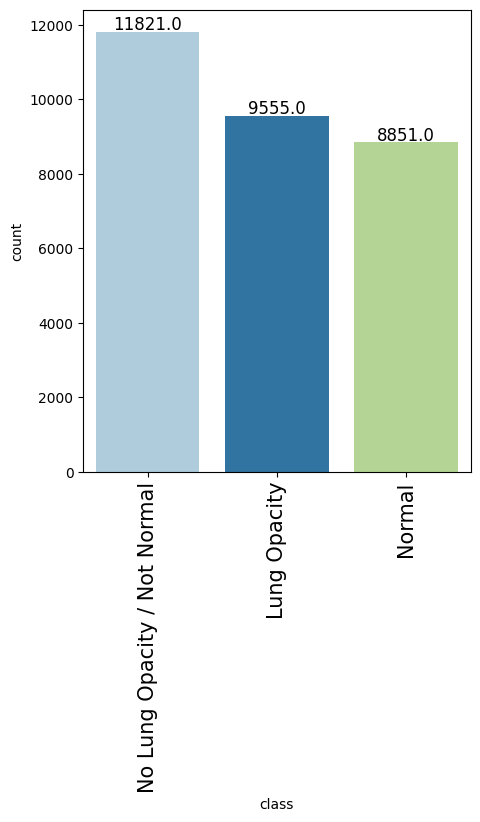

In [70]:
labeled_barplot(merged_df, "class")

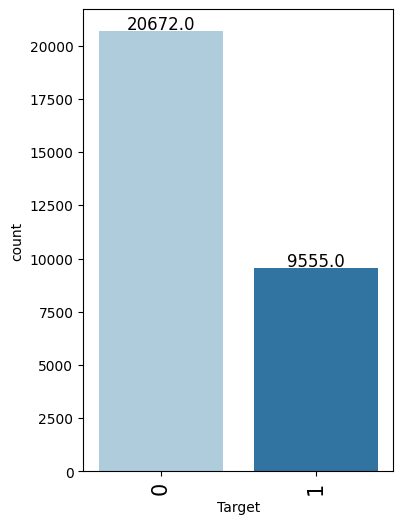

In [71]:
labeled_barplot(merged_df, "Target")

Let's understand the missing values, when the target is 0 and the person is non-pnenomic then there will not be any boundary box and hence the values of x,y,width and height would be Nan/missing.

In [73]:
merged_df.groupby('Target').agg(
    total_rows=('patientId', 'count'),            
    unique_patients=('patientId', 'nunique'),      
    missing_x=('x', lambda x: x.isna().sum()),
    missing_y=('y', lambda x: x.isna().sum()),
    missing_width=('width', lambda x: x.isna().sum()),
    missing_height=('height', lambda x: x.isna().sum())
).reset_index()

Target  total_rows  unique_patients  missing_x  missing_y  missing_width  \
0       0       20672            20672      20672      20672          20672   
1       1        9555             6012          0          0              0   

   missing_height  
0           20672  
1               0

##### Observation:

* There are 30227 rows and 7 columns in merged Dataframe
* There are 4 column with **float** datatype - x,y,width,height
* There are 2 column with **object** datatype - patientId, class
* There is 1 column with **int** datatype - Target
* x,y,width,height,Target are numerical values
* patientId and class are categorical value
* There are 20672 missing values, upon analysis foundthat all the missing values are for non-pnemonic persons

###  3. Map training and testing images to its annotations

In [76]:
#Create Dataframe considering only pnenomic persons
bbox_df = merged_df[merged_df['Target'] == 1]

In [77]:
#Check count and percentage of all missing values across all columns
pd.DataFrame({'Count':bbox_df.isnull().sum()[bbox_df.isnull().sum()>0],'Percentage':(bbox_df.isnull().sum()[bbox_df.isnull().sum()>0]/bbox_df.shape[0])*100})

Empty DataFrame
Columns: [Count, Percentage]
Index: []

In [78]:
annotation_dict = bbox_df.groupby('patientId')[['x', 'y', 'width', 'height']].apply(
    lambda x: x.values.tolist()
).to_dict()

In [79]:
len(annotation_dict)

6012

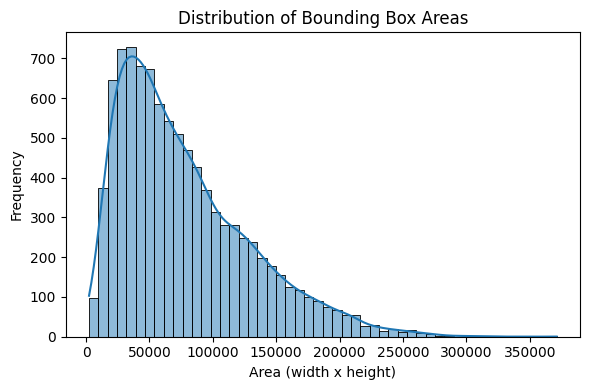

In [80]:
#Viualize area for Bounding Box
bbox_df['area'] = bbox_df['width'] * bbox_df['height']

plt.figure(figsize=(6, 4))
sns.histplot(bbox_df['area'], bins=50, kde=True)
plt.title("Distribution of Bounding Box Areas")
plt.xlabel("Area (width x height)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

###  4. Preprocessing and Visualisation of different classes

In [132]:
#Defining Image size
target_size = (1024, 1024)

In [150]:
# Set your image directory 
image_dir = f"{train_images}//stage_2_train_images"

# List all DICOM files
dicom_files = [f for f in os.listdir(image_dir) if f.endswith('.dcm')]

# Create a dictionary to store resized images
resized_images = {}

# Resize and normalize all images
for file in tqdm(dicom_files, desc="Resizing images"):
    dcm_path = f"{train_images}//stage_2_train_images//{patient_id}.dcm"
    dcm = pydicom.dcmread(dcm_path)
    img = dcm.pixel_array.astype(np.float32)
    img /= np.max(img)  # normalize
    img_resized = resize(img, target_size, anti_aliasing=True)
    resized_images[patient_id] = img_resized  # store in dictionary


Resizing images: 100%|███████████████████████████████████████████████████████████| 26684/26684 [46:50<00:00,  9.50it/s]


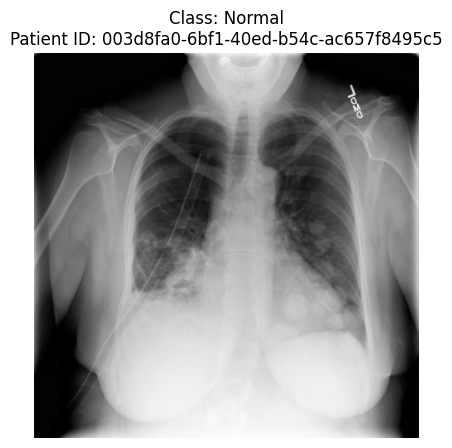

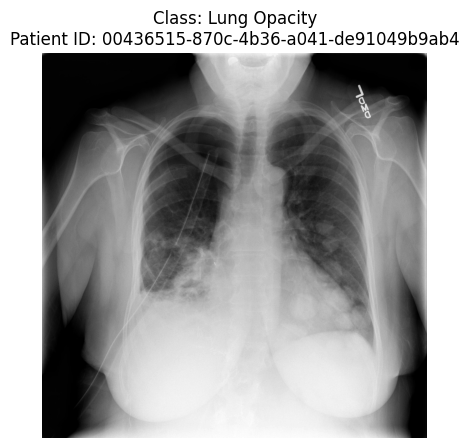

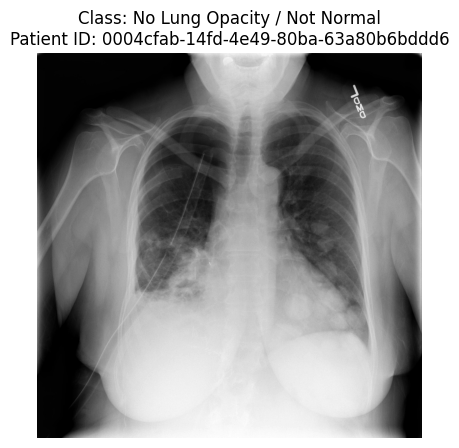

In [152]:
class_labels = ['Normal', 'Lung Opacity', 'No Lung Opacity / Not Normal']

# Loop through each class and show a resized image
for class_name in class_labels:
    patient_id = df_class_info_clean[df_class_info_clean['class'] == class_name].iloc[0]['patientId']
    plt.figure(figsize=(5, 5))
    plt.imshow(img_resized, cmap='gray')
    plt.title(f"Class: {class_name}\nPatient ID: {patient_id}")
    plt.axis('off')
    plt.show()

###  5. Display images with bounding box

In [173]:
def show_image_with_bboxes(patient_id, image_dir, bbox_dict):
    dcm_path = f"{train_images}//stage_2_train_images//{patient_id}.dcm"
    dcm = pydicom.dcmread(dcm_path)
    img = dcm.pixel_array

    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.title(f"Patient ID: {patient_id}")
    plt.axis('off')
        
    for bbox in bbox_dict[patient_id]:
        x, y, w, h = bbox
        rect = plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=2)
        plt.gca().add_patch(rect)
    
    plt.show()

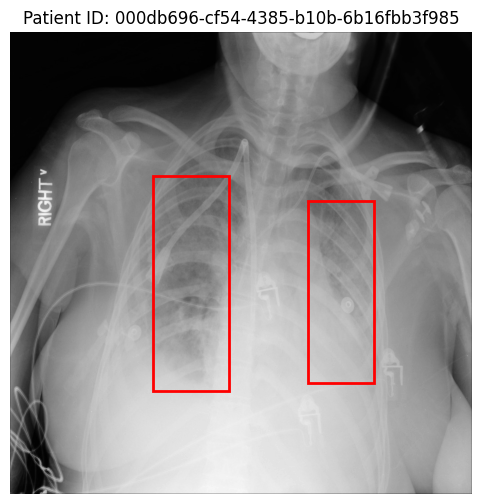

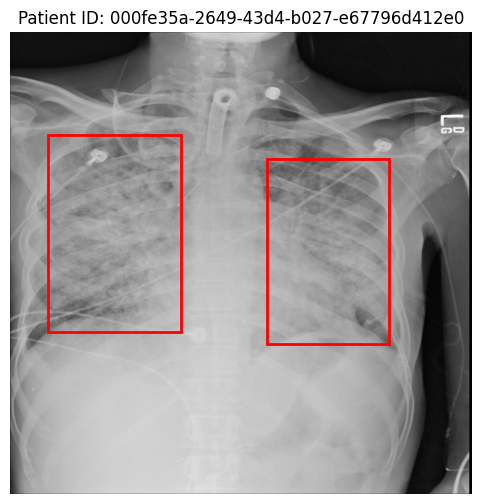

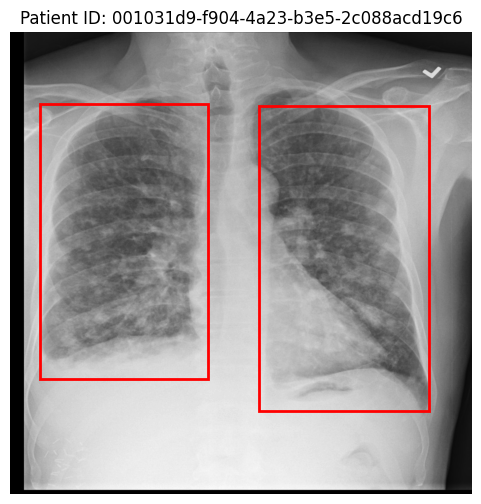

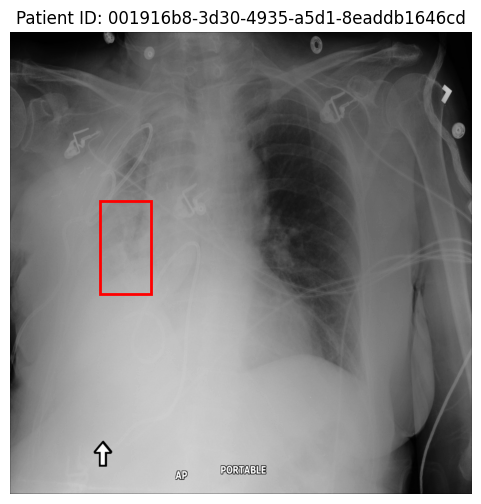

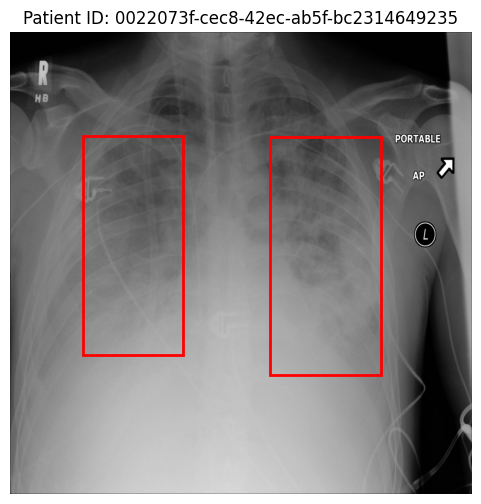

In [175]:
# Show bounding boxes for first 3 lung opacity images
lung_opacity_ids = list(annotation_dict.keys())

for pid in lung_opacity_ids[:5]:
    show_image_with_bboxes(pid, image_dir=train_images, bbox_dict=annotation_dict)